In [1]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
import seaborn as sns
import numpy as np

from metadata.etfs import etfs_large, etfs_small
from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [2]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
results_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs", "results")

des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = [
    "lasso1_nocluster",
    "pairwise-granger_nocluster",
    "multivariate-granger_nocluster",
    "dynotears_rollingcluster_k5",
    "var-lingam_rollingcluster_k5",
]
metric_names = ["mse", "mae", "mse_crisis", "mae_crisis"] # ["stability", "mse", "mae", "mse_crisis", "mae_crisis"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [14]:
warnings.simplefilter("ignore")


all_metrics = []
all_rolling_metrics = []
all_stability = []
all_parents = []
for fs in fs_methods:

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        if (etf_focus != etf) and (etf_focus is not None):
            continue
        else:
            pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions']

        # filter predictions
        predictions_df.loc[(predictions_df['prediction_zscore'] == 1)|(predictions_df['prediction_zscore'] == -1), 'prediction_zscore'] = 0
        predictions_df.loc[(predictions_df['prediction'] == 1)|(predictions_df['prediction'] == -1), 'prediction'] = 0

        predictions_covid_df = predictions_df.loc["2020-01-01":"2021-01-01"]
        predictions_gfc_df = predictions_df.loc["2007-06-01":"2008-06-01"]
        predictions_china_crisis_df = predictions_df.loc["2015-01-01":"2016-12-31"]
        crisis_predictions = [predictions_covid_df, predictions_gfc_df, predictions_china_crisis_df]

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["true"] - rolling_metric_df["prediction"]

        # rolling mse
        rolling_metric_df["rolling_var"] = rolling_metric_df["prediction"].rolling(12).var()
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["true"] - rolling_metric_df["prediction"]).pow(2).rolling(12).mean()
        rolling_metric_df["rolling_mse"] = rolling_metric_df["rolling_var"] + rolling_metric_df["rolling_bias"] * 100
        rolling_metric_df["rolling_var"] = (rolling_metric_df["rolling_var"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["rolling_bias"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df = rolling_metric_df[["diff", "rolling_mse", "rolling_var", "rolling_bias"]]

        # add info
        rolling_metric_df["fs"] = fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"]) * 100
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"]) * 100

        crisis_mse = []
        crisis_mae = []
        for tmp_pred in crisis_predictions:
            tmp_mse = mean_squared_error(tmp_pred["true"], tmp_pred["prediction"])
            tmp_mae = mean_absolute_error(tmp_pred["true"], tmp_pred["prediction"])

            crisis_mse.append(tmp_mse)
            crisis_mae.append(tmp_mae)
        crisis_mse = np.mean(crisis_mse) * 100
        crisis_mae = np.mean(crisis_mae) * 100

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]

        # save parents
        parents_of_target_df["fs"] = fs
        parents_of_target_df["etf"] = etf
        
        tot = len(parents_of_target_df["date"].unique())
        stability_df = (parents_of_target_df.fillna(0).groupby(["cluster"]).sum()[["value"]] / tot).sort_values(by="value", ascending=False)
        stability_df = pd.concat({etf: stability_df}, names=['etf'])
        stability.append(stability_df)

        stability_measure = (stability_df).sum().iloc[0] / stability_df.shape[0]
        metrics_df = pd.DataFrame({
            "fs": fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            # "bias": [bias],
            # "var": [var],
            "mse_crisis": [crisis_mse], 
            "mae_crisis": [crisis_mae],
            "stability": stability_measure})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
        all_parents.append(parents_of_target_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
    all_stability.append(pd.concat(stability))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
all_parents_df = pd.concat(all_parents)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

## Boxplots with summary statistics

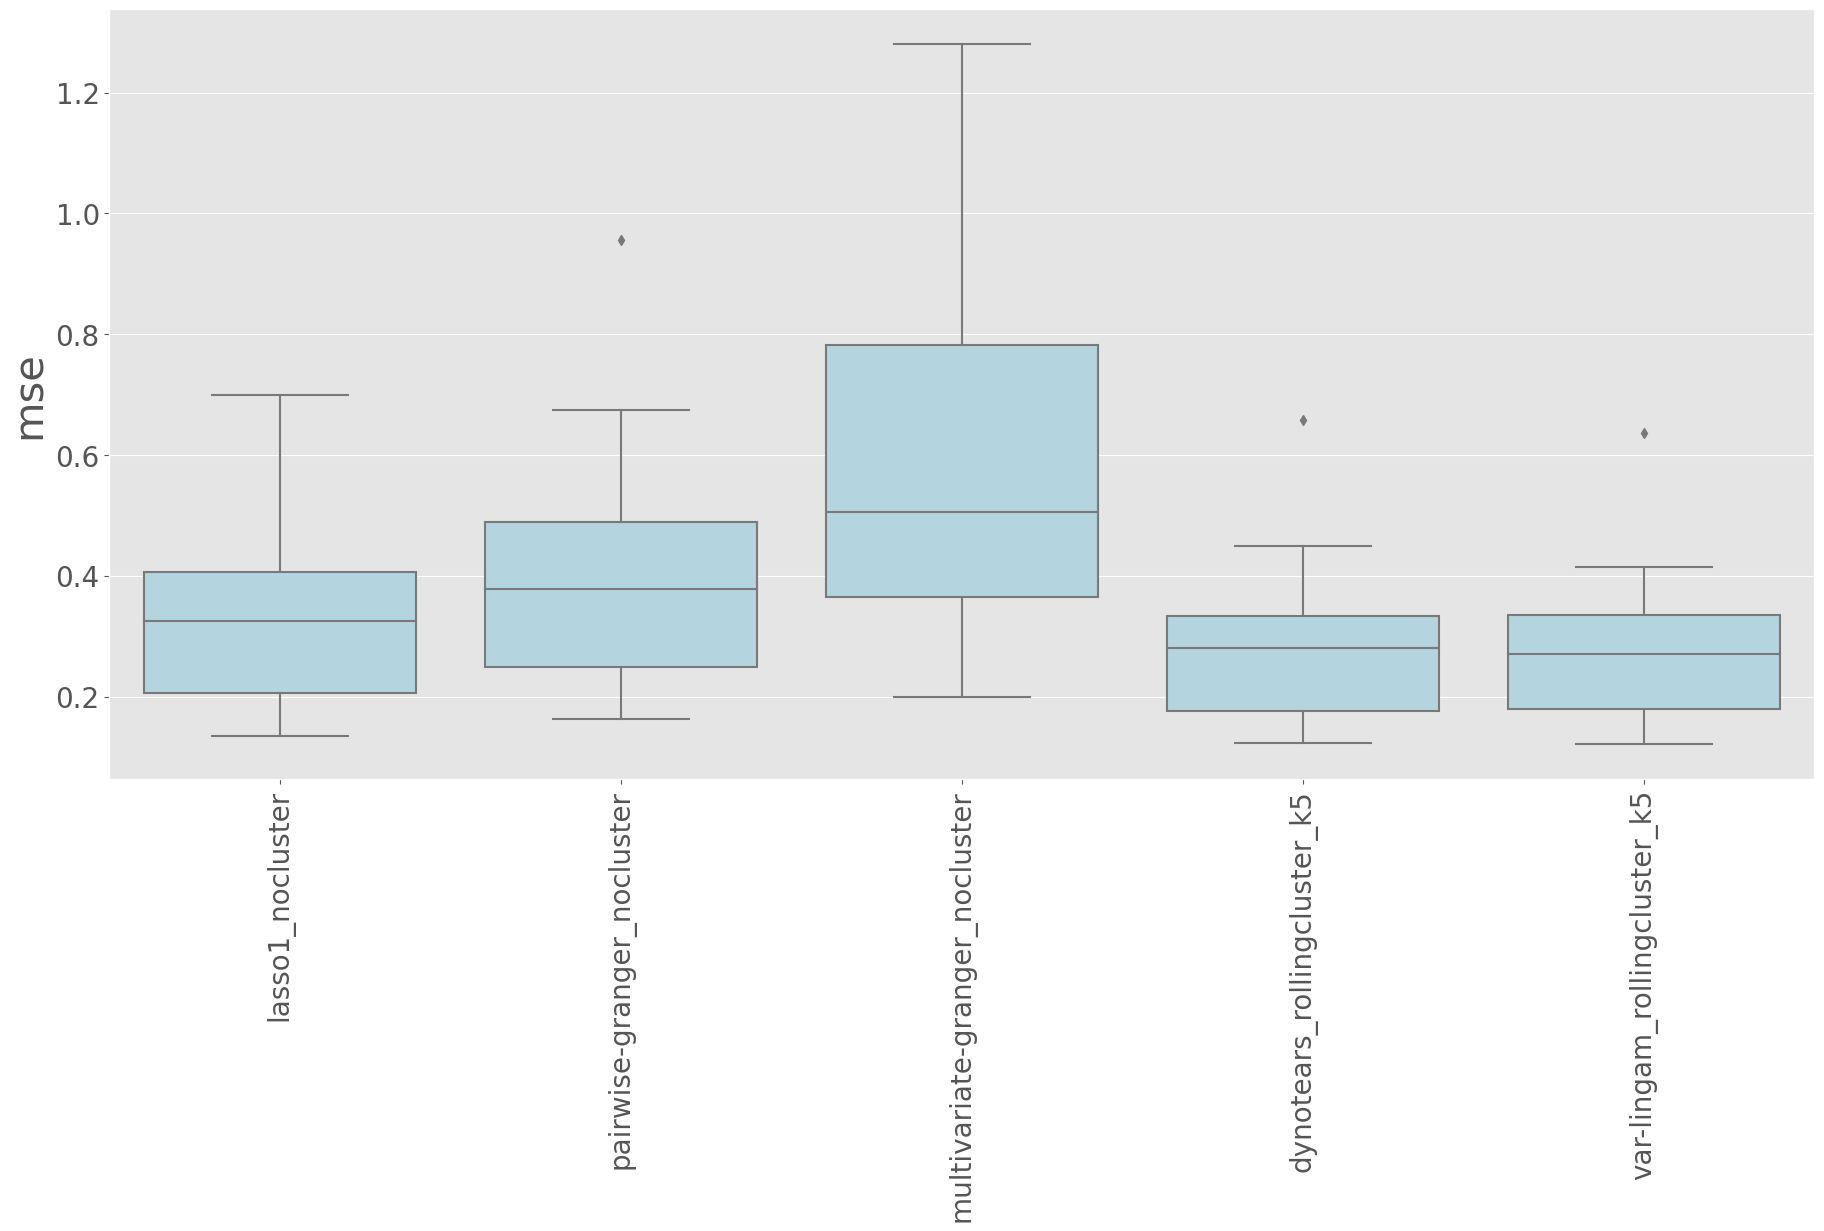

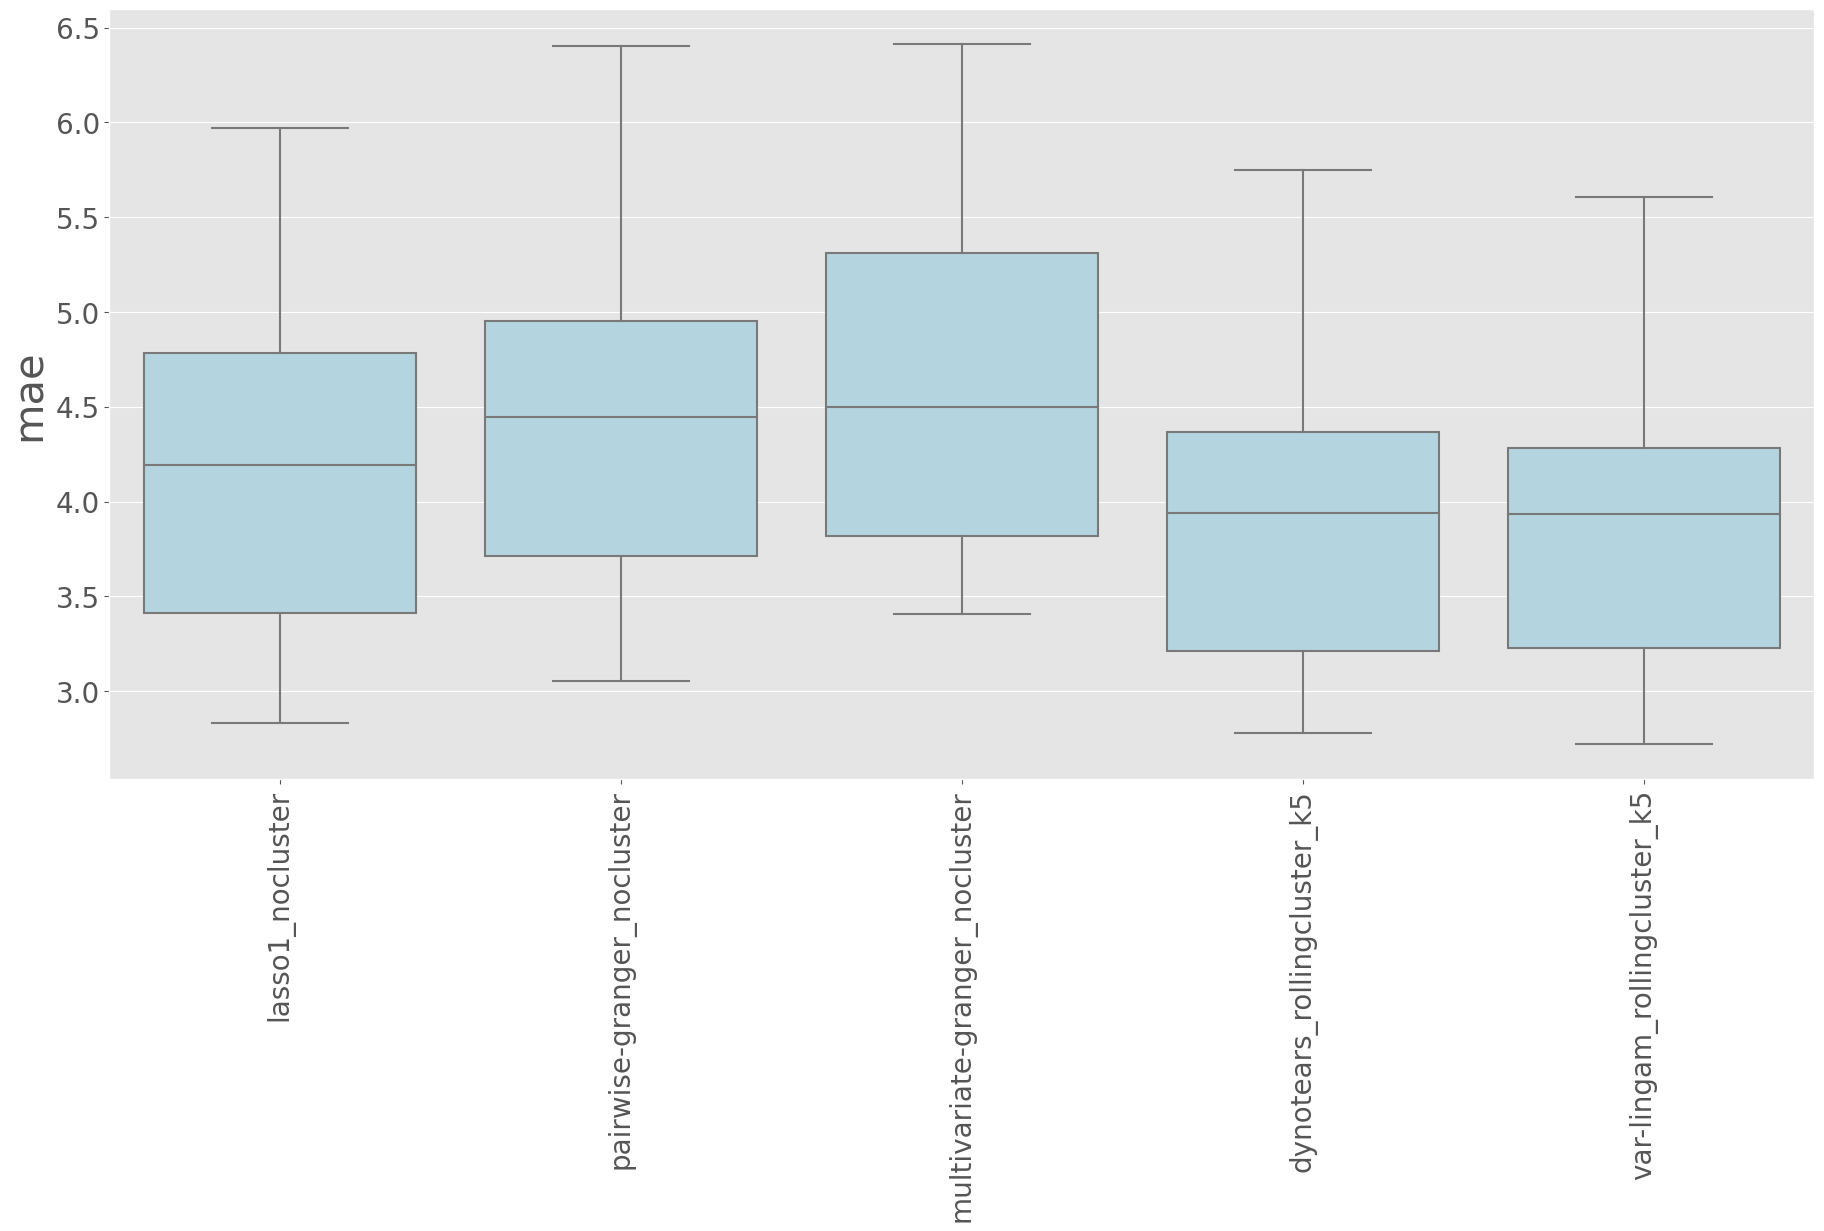

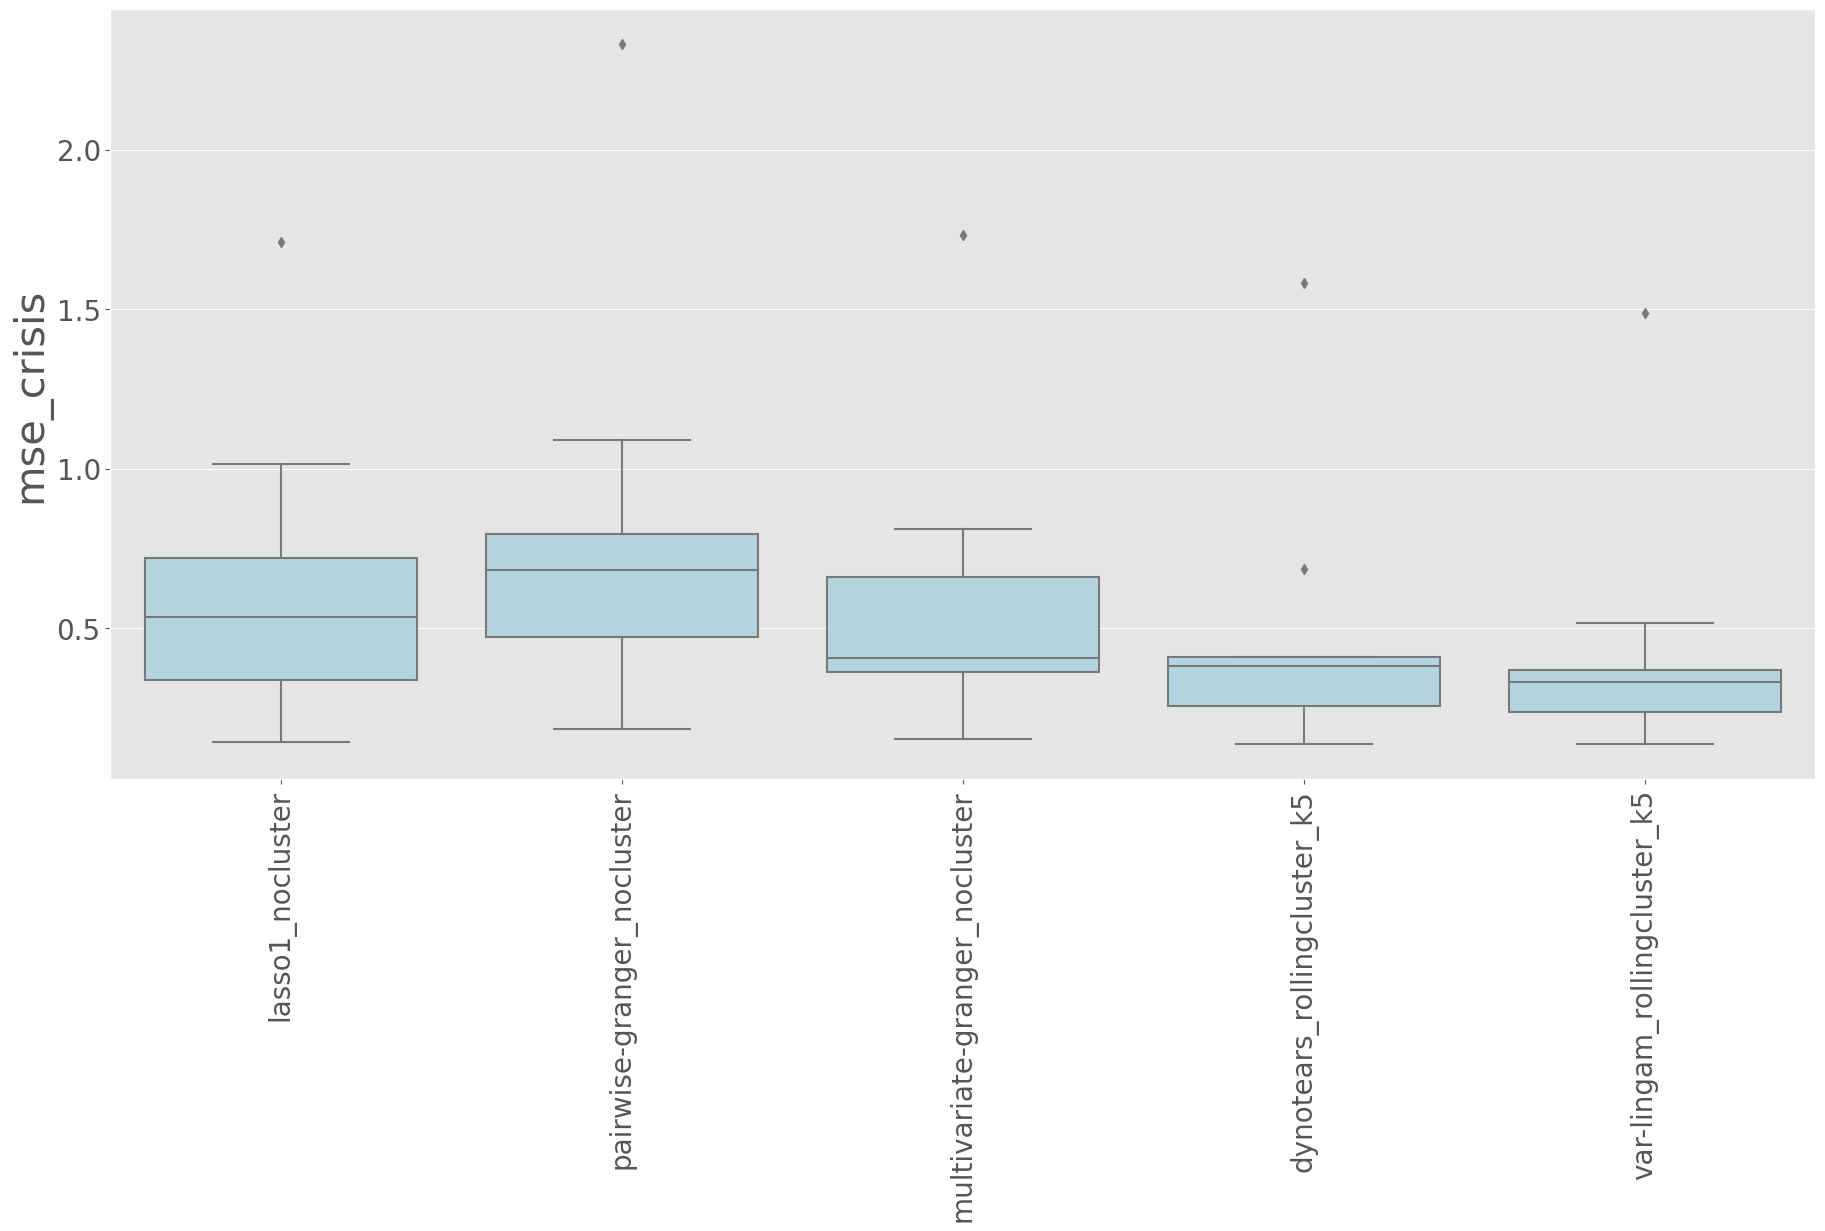

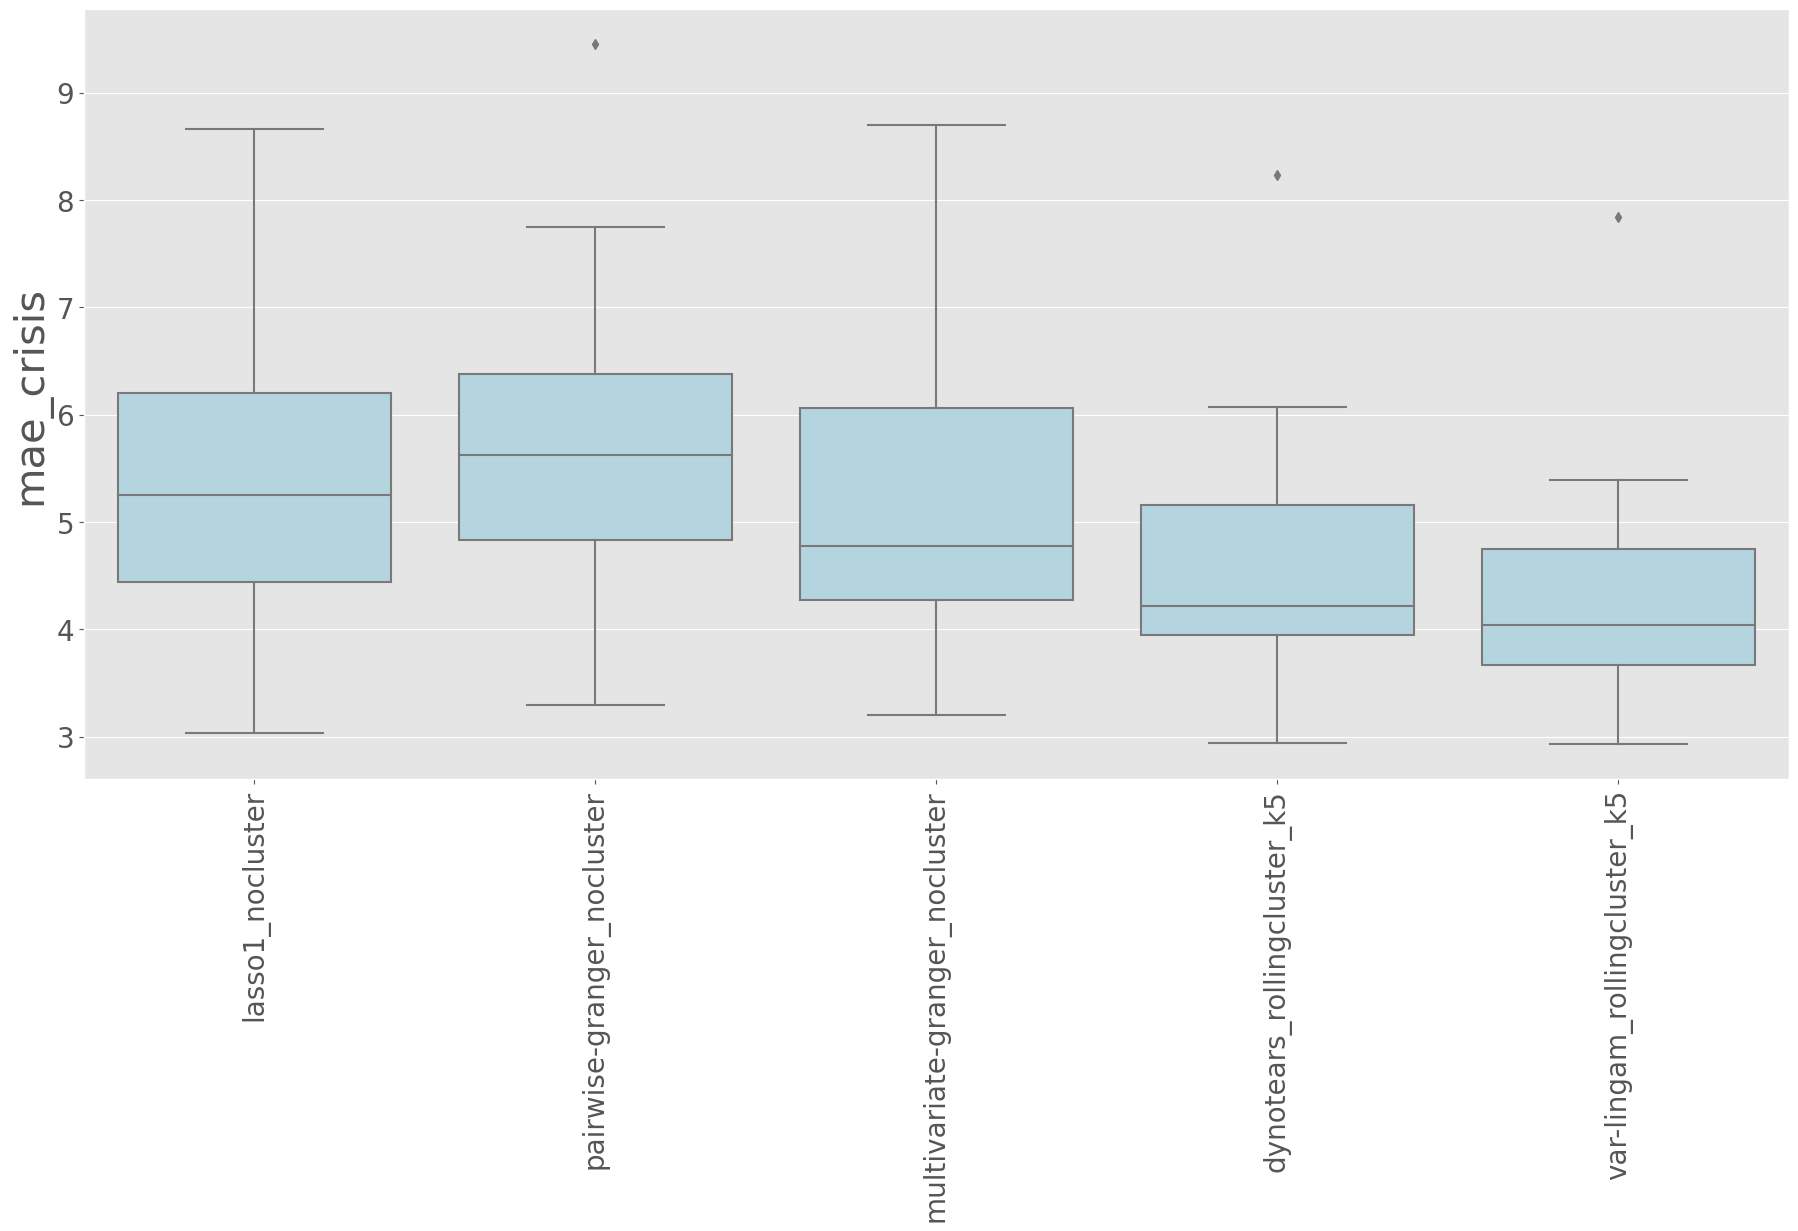

In [15]:
for m in metric_names:
    boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=30)
    ax.set_xlabel("", fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    # ax.legend(loc="best",fontsize=15)
    plt.xticks(rotation=90)
    fig.savefig(os.path.join(results_path, f'boxplot_agg_{m}_fs.png'))

## Prediction error over time

### (a) Bias-Variance Trade-off

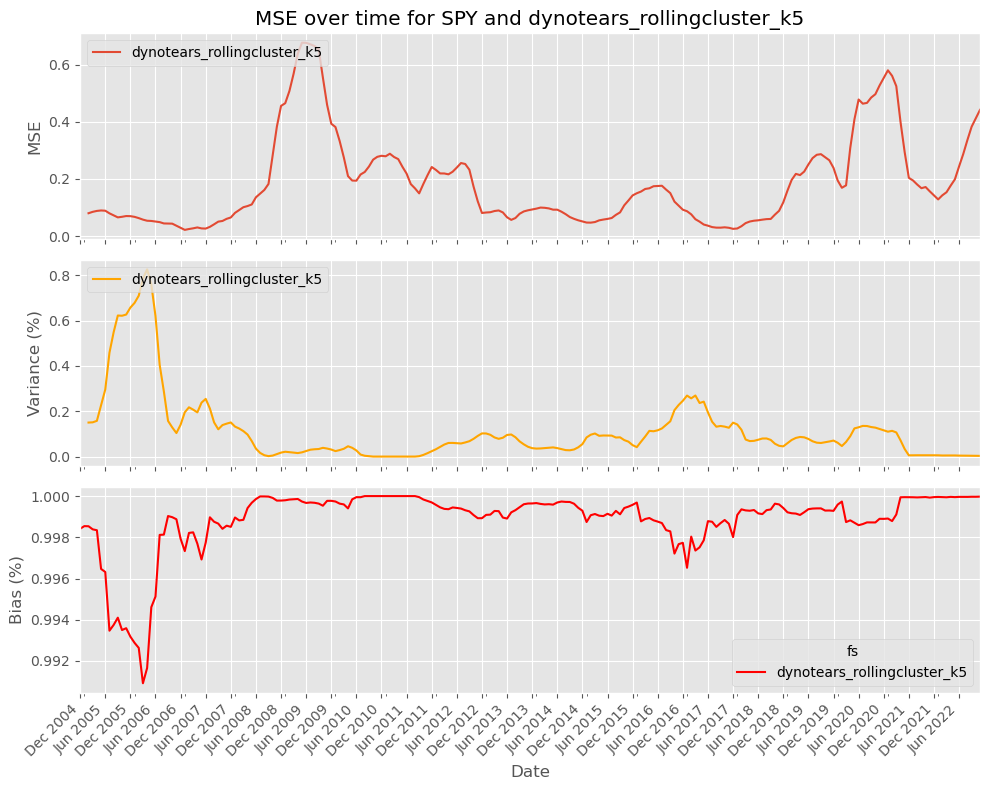

In [5]:
etf = "SPY"
fs = "dynotears_rollingcluster_k5"

# mse
etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
etf_rolling_metrics_df["diff_lasso_var-lingam"] = 1

# variance
etf_rolling_variance_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_var")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel()
etf_rolling_variance_df = etf_rolling_variance_df.rolling(3).mean()
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel(1) 

# bias
etf_rolling_bias_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_bias")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel()
etf_rolling_biass_df = etf_rolling_bias_df.rolling(3).mean()
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel(1) 

# plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# plotting on the upper subplot
etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
axs[0].set_title(f'MSE over time for {etf} and {fs}')
axs[0].set_ylabel('MSE')
axs[0].legend(loc='upper left')

# plotting on the upper subplot
etf_rolling_variance_df.plot(ax=axs[1], color="orange")
# axs[1].set_title(f'Variance over time for {etf}')
axs[1].set_ylabel('Variance (%)')
axs[1].legend(loc='upper left')

# plotting on the lower subplot
etf_rolling_bias_df.plot(ax=axs[2], color="red")
# axs[2].set_title(f'Bias over time for {etf}')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Bias (%)')

# adding months and years to the index of the plot
tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
axs[2].set_xticks(tick_positions)
axs[2].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

# adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

### (b) Rolling MSE

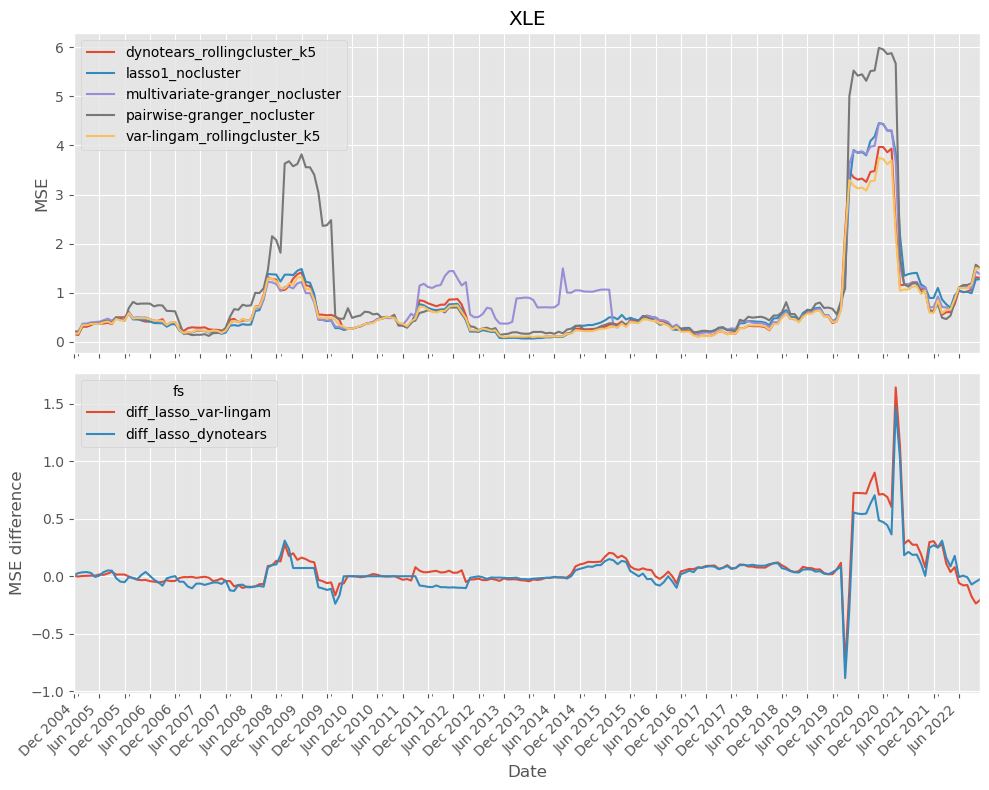

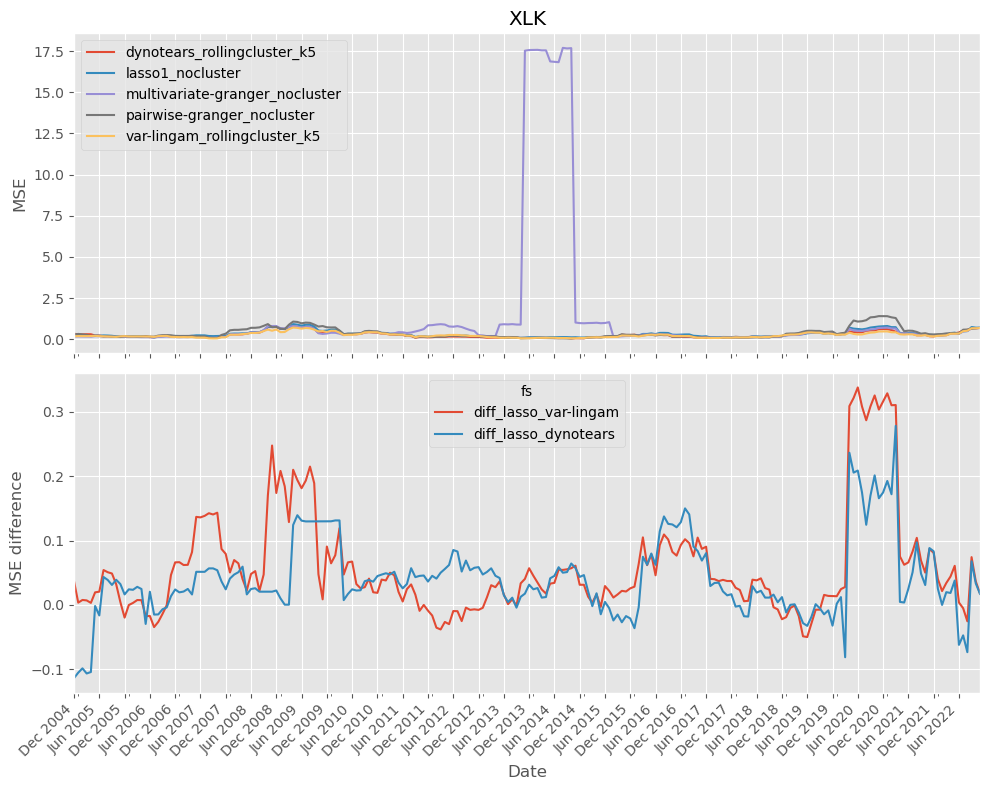

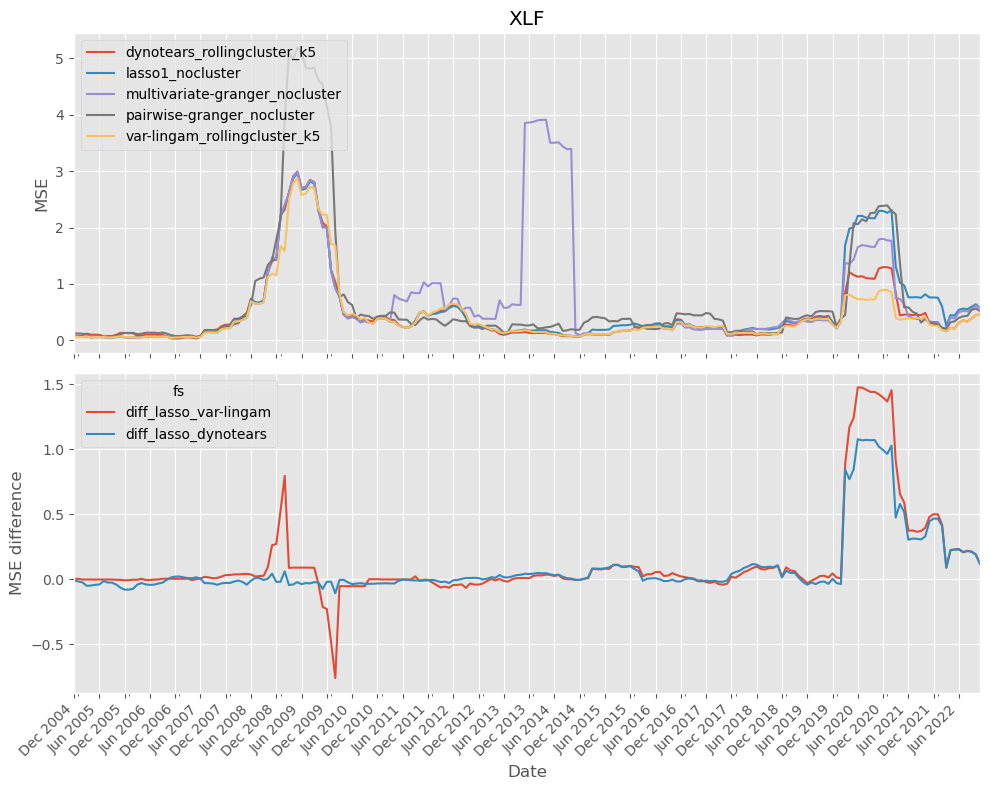

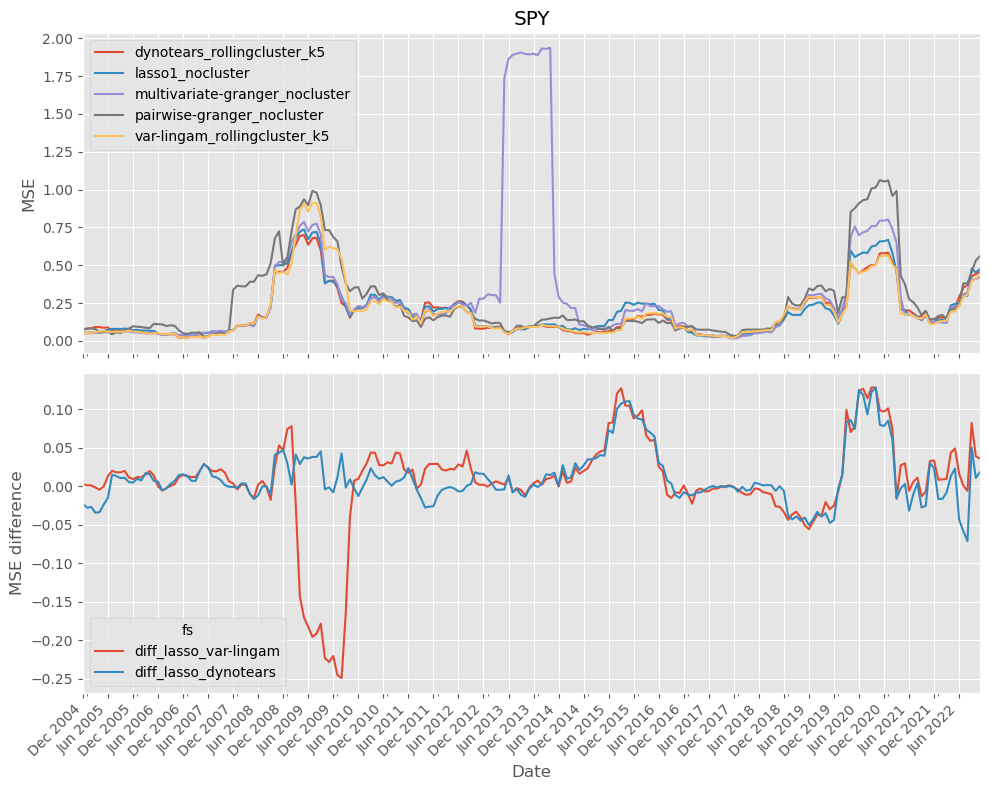

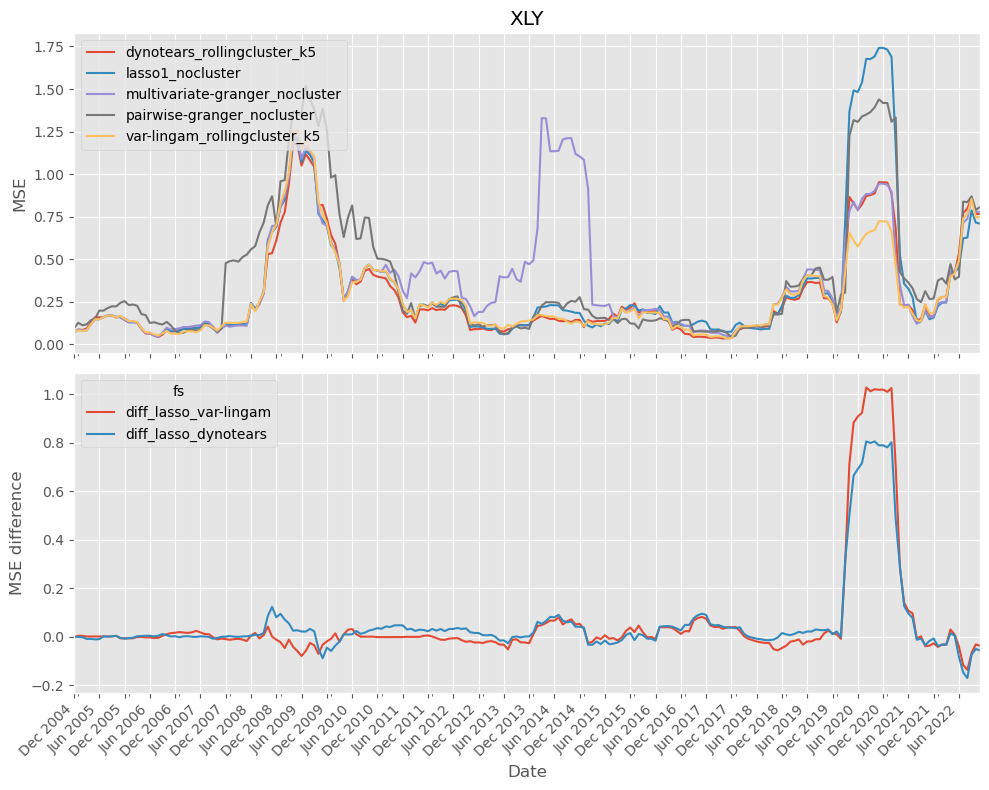

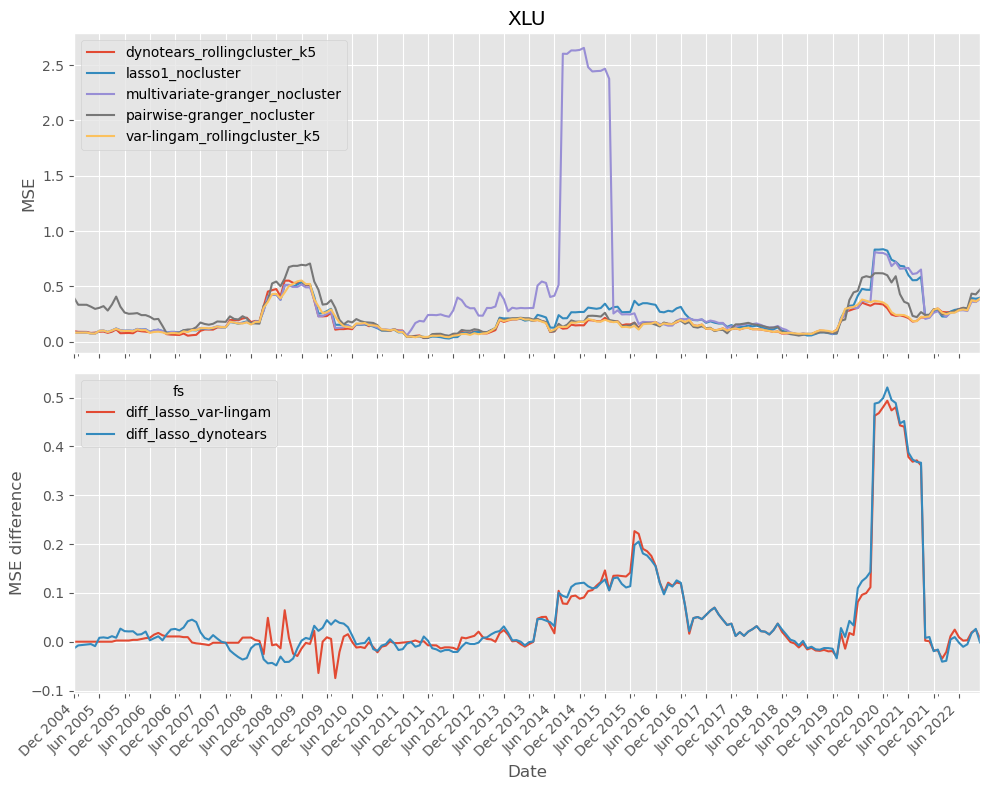

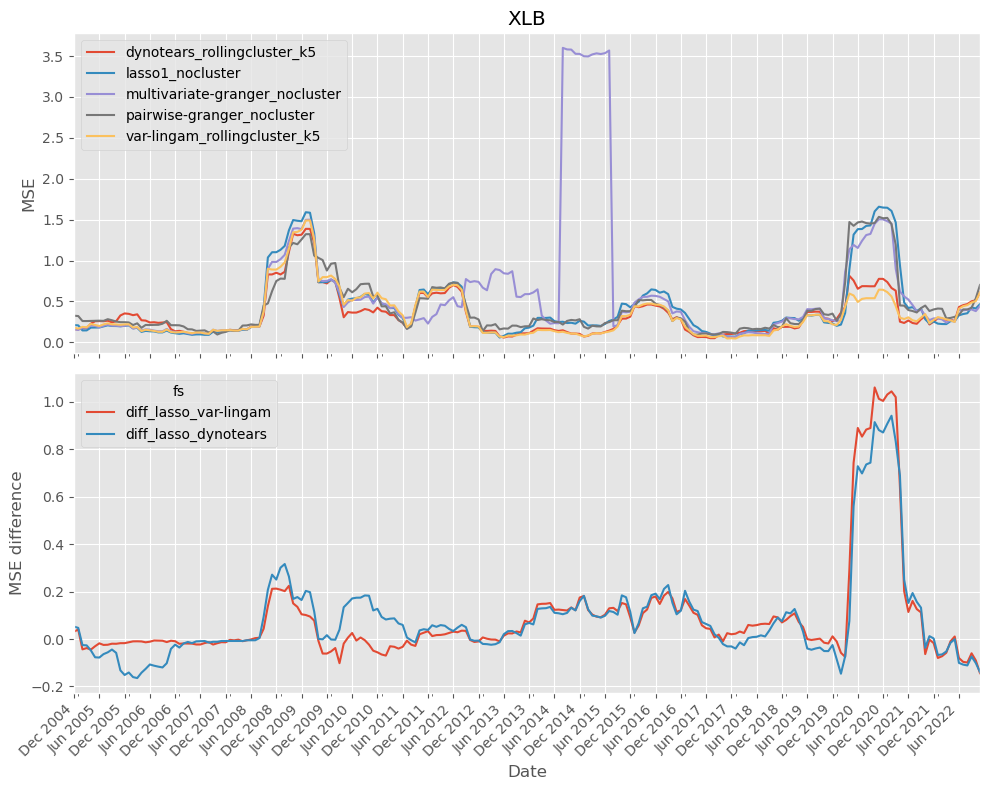

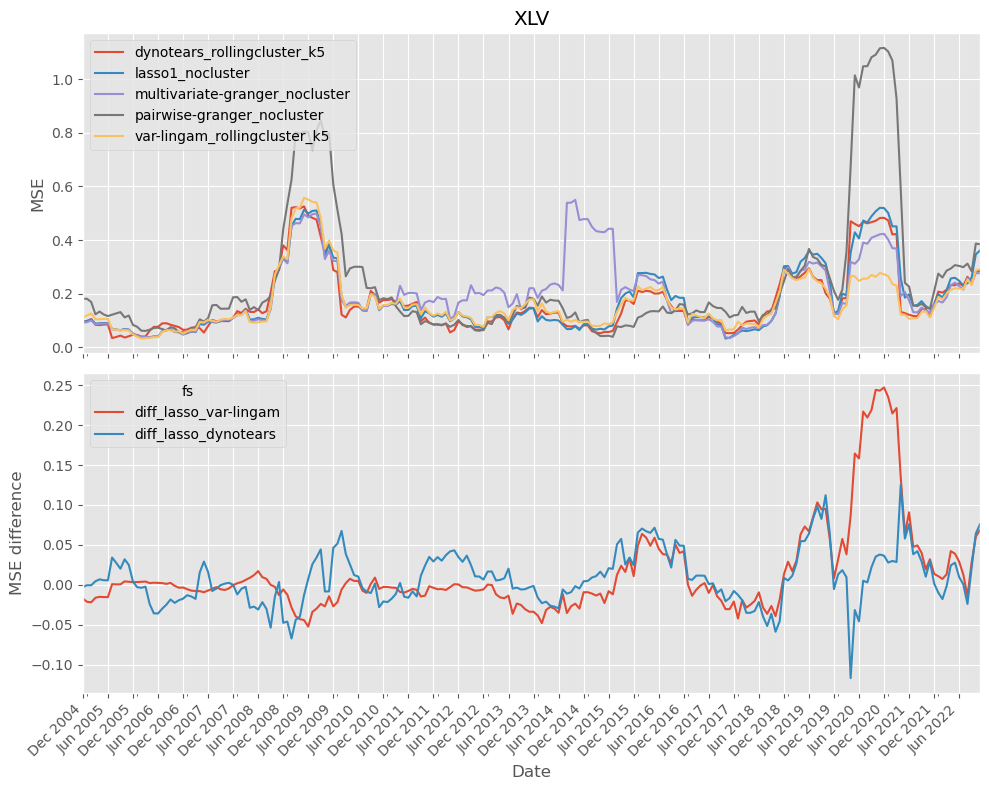

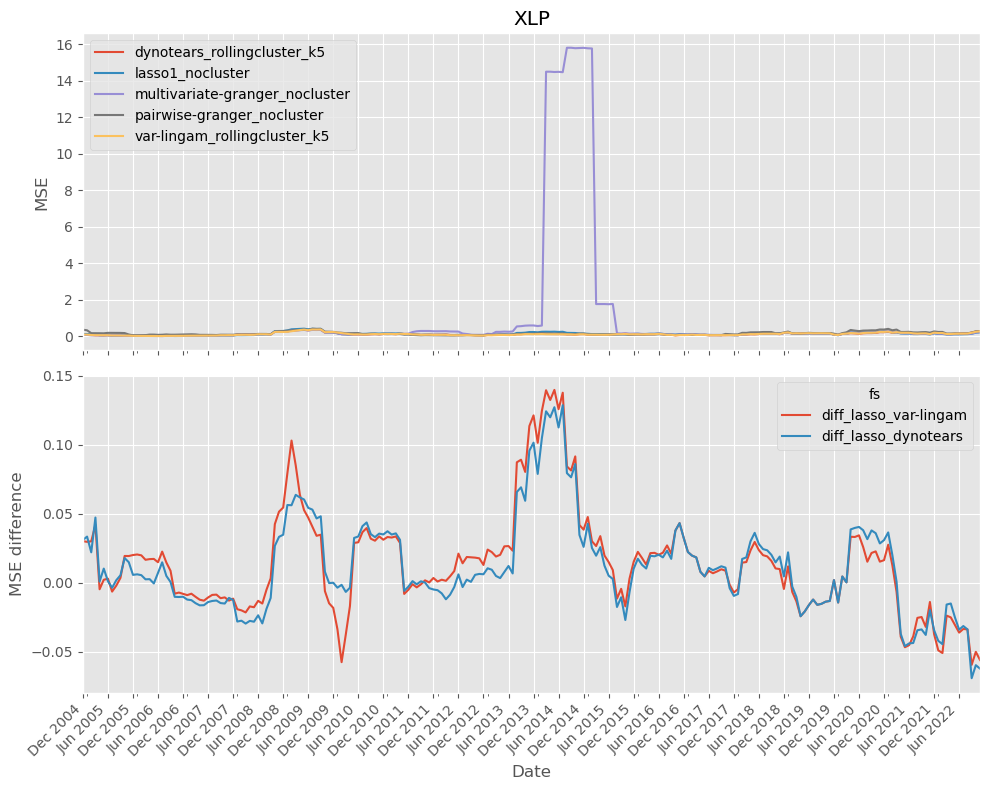

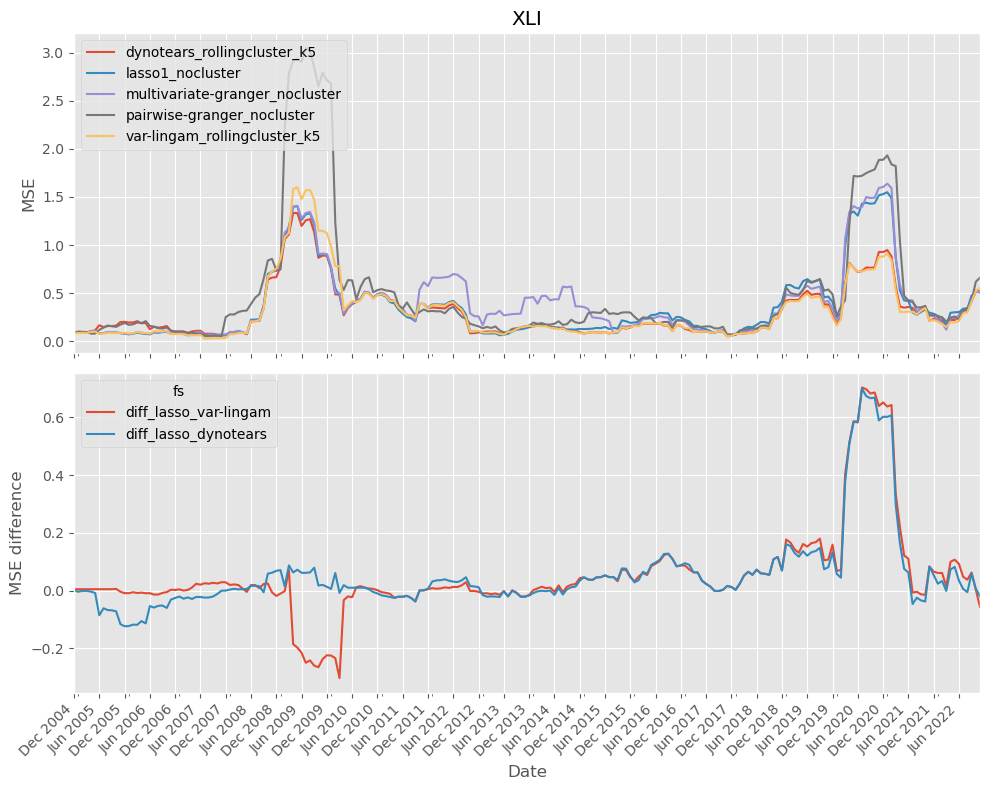

In [6]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df["diff_lasso_var-lingam"] = etf_rolling_metrics_df["lasso1_nocluster"] - etf_rolling_metrics_df["var-lingam_rollingcluster_k5"]
    etf_rolling_metrics_df["diff_lasso_dynotears"] = etf_rolling_metrics_df["lasso1_nocluster"] - etf_rolling_metrics_df["dynotears_rollingcluster_k5"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_lasso_var-lingam", "diff_lasso_dynotears"], axis=1).plot(ax=axs[0])
    # etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df[["diff_lasso_var-lingam", "diff_lasso_dynotears"]].plot(ax=axs[1])
    # etf_rolling_metrics_df[["diff_lasso_var-lingam"]].plot(ax=axs[1])
    # axs[1].set_title(f'MSE difference between lasso and a causal model for {etf}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_mse.png'))

    # Show the plot
    plt.show()

## Selected parents over time

In [7]:
etf = "SPY"
fss = ["var-lingam", "multivariate-granger"]

In [8]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[0]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

date


In [9]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[1]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

date


## Summary Statistics Sorted by MSE

In [10]:
all_metrics_df.sort_values(by=["mse"], ascending=True)

mse       mae  mse_crisis  \
fs                             etf                                   
var-lingam_rollingcluster_k5   XLP  0.121004  2.719495    0.160850   
dynotears_rollingcluster_k5    XLP  0.124097  2.780173    0.158815   
lasso1_nocluster               XLP  0.134633  2.830974    0.160124   
pairwise-granger_nocluster     XLP  0.163637  3.054432    0.237137   
var-lingam_rollingcluster_k5   XLV  0.164190  3.172548    0.182044   
dynotears_rollingcluster_k5    XLV  0.168300  3.090107    0.306541   
                               XLU  0.172661  3.202696    0.277304   
var-lingam_rollingcluster_k5   XLU  0.174784  3.335570    0.265554   
lasso1_nocluster               XLV  0.179847  3.227739    0.310550   
dynotears_rollingcluster_k5    SPY  0.189933  3.241779    0.348090   
var-lingam_rollingcluster_k5   SPY  0.194911  3.194146    0.337544   
multivariate-granger_nocluster XLV  0.200191  3.405135    0.260374   
lasso1_nocluster               SPY  0.202239  3.351305    0.378653   
                               XLU  0.220620  3.596855    0.508228   
pairwise-granger_nocluster     XLU  0.234881  3.734417    0.412893   
                               XLV  0.242763  3.704043    0.628194   
var-lingam_rollingcluster_k5   XLK  0.258626  3.977932    0.399966   
pairwise-granger_nocluster     SPY  0.265559  3.699144    0.717714   
dynotears_rollingcluster_k5    XLK  0.278650  4.253828    0.474210   
var-lingam_rollingcluster_k5   XLY  0.283462  3.895656    0.428735   
dynotears_rollingcluster_k5    XLY  0.283854  3.823402    0.533960   
                               XLI  0.307414  4.053267    0.499316   
var-lingam_rollingcluster_k5   XLI  0.313212  3.986272    0.479318   
multivariate-granger_nocluster SPY  0.313317  3.776458    0.445013   
lasso1_nocluster               XLK  0.315494  4.428433    0.567690   
                               XLY  0.334310  4.078617    0.926544   
var-lingam_rollingcluster_k5   XLB  0.342474  4.384429    0.400953   
dynotears_rollingcluster_k5    XLB  0.342730  4.406802    0.467075   
lasso1_nocluster               XLI  0.358000  4.306633    0.800893   
multivariate-granger_nocluster XLU  0.358407  3.949290    0.488882   
pairwise-granger_nocluster     XLK  0.365706  4.519058    1.000446   
multivariate-granger_nocluster XLY  0.383375  4.419079    0.524872   
pairwise-granger_nocluster     XLY  0.391272  4.372524    0.965261   
multivariate-granger_nocluster XLI  0.401840  4.578564    0.837315   
var-lingam_rollingcluster_k5   XLF  0.413995  4.540302    0.649006   
lasso1_nocluster               XLB  0.422245  4.899378    0.893853   
pairwise-granger_nocluster     XLB  0.439382  4.913992    0.853227   
dynotears_rollingcluster_k5    XLF  0.449396  4.721811    0.891043   
pairwise-granger_nocluster     XLI  0.506684  4.963217    1.094186   
lasso1_nocluster               XLF  0.534614  5.015827    1.366400   
multivariate-granger_nocluster XLB  0.608036  5.316780    0.827477   
var-lingam_rollingcluster_k5   XLE  0.635989  5.603940    2.079520   
dynotears_rollingcluster_k5    XLE  0.657820  5.746179    2.203611   
pairwise-granger_nocluster     XLF  0.674872  5.538294    1.423759   
lasso1_nocluster               XLE  0.698907  5.969331    2.385336   
multivariate-granger_nocluster XLF  0.707160  5.288839    1.098868   
                               XLE  0.806247  6.411175    2.427609   
pairwise-granger_nocluster     XLE  0.956422  6.405162    3.330103   
multivariate-granger_nocluster XLP  0.979139  3.721513    0.169403   
                               XLK  1.279741  5.367394    0.511394   

                                    mae_crisis  stability  
fs                             etf                         
var-lingam_rollingcluster_k5   XLP    3.230603   0.200000  
dynotears_rollingcluster_k5    XLP    3.228827   0.255914  
lasso1_nocluster               XLP    3.127148   5.544053  
pairwise-granger_nocluster     XLP    3.781362  12.797235  
var-lingam_rollingcluster_k5   XLV    3.

In [11]:
all_metrics_df.sort_values(by=["mse_crisis"], ascending=True)

,,mse,mae,mse_crisis,mae_crisis,stability
fs,etf,,,,,
dynotears_rollingcluster_k5,XLP,0.124097,2.780173,0.158815,3.228827,0.255914
lasso1_nocluster,XLP,0.134633,2.830974,0.160124,3.127148,5.544053
var-lingam_rollingcluster_k5,XLP,0.121004,2.719495,0.160850,3.230603,0.200000
multivariate-granger_nocluster,XLP,0.979139,3.721513,0.169403,3.306797,25.773050
var-lingam_rollingcluster_k5,XLV,0.164190,3.172548,0.182044,3.535222,0.232258
pairwise-granger_nocluster,XLP,0.163637,3.054432,0.237137,3.781362,12.797235
multivariate-granger_nocluster,XLV,0.200191,3.405135,0.260374,4.061348,24.333333
var-lingam_rollingcluster_k5,XLU,0.174784,3.335570,0.265554,4.120955,0.224242
dynotears_rollingcluster_k5,XLU,0.172661,3.202696,0.277304,4.399508,0.265185
